# Portfolio Visualization Demonstration

For my master's thesis, I explored applications of social network analysis in the portfolio construction and allocation process. This jupyter notebook uses data from my thesis to demonstrate portfolio visualization and analysis. Additional performance metrics will be added in the future.

## Import packages

In [1]:
# import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# What I worked on!
from MakePortfolio import make_portfolio, glance

from MakePortfolio import plot_sector, plot_init_weights, plot_risk_return, plot_sharpe, price_to_return,\
                          return_to_cumul, plot_stock_annual, calendar_heatmap, plot_sector_metric, plot_ws_sector

## Set plotting style

In [2]:
sns.set(context='talk',
        style='ticks', # font_scale=0.8,
        palette= 'colorblind', 
        rc={ # 'axes.xmargin':0, 'axes.ymargin': 0,
            'axes.grid': True, 'axes.grid.axis': 'both', 
            'axes.grid.which': 'major', 'axes.facecolor': 'white',
            'axes.axisbelow': True, 'axes.edgecolor': 'black', 
            'axes.linewidth' : 0.8, 'lines.linewidth': 1,
            'grid.color': '#ededed', 'grid.linestyle': ':',
            'patch.edgecolor': 'black', 'patch.linewidth': 1,
            'legend.edgecolor': 'black','legend.fancybox': False,
            'axes.spines.left': True, 'axes.spines.right': True,
            'axes.spines.top': True, 'axes.spines.bottom': True,
            'figure.autolayout': True}) # plt.tick_params(labelright=True)

## Load data

### Stock universe

The stock universe is first limited to stocks listed on the Standard & Poor's 500 Index by (Sunday) May 17, 2015. Using historical prices between May 18, 2012 and May 17, 2015, the stock universe is further subset to 300 stocks with the highest signal-to-noise ratio. Signal-to-noise ratio is calculated as return over standard deviation. The stock universe includes active and delisted stocks. Portfolio performance is observed between (Monday) May 18, 2015 and December, 2020.

In [3]:
# Load pickled end of day prices from Quandl
my_path = '/Users/w2/MAL/SAM/'
data_path1 = my_path + 'Sharadar2'

df = pd.read_pickle(data_path1)
df.drop(columns={'dividends'}, inplace=True)
df.columns = df.columns.droplevel(0)
df.tail(3)

ticker,A,AAL,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XOM,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2020-12-08,117.01,17.63,124.38,107.69,100.43,106.80,249.86,495.28,146.13,50.36,...,146.19,42.24,54.28,22.86,98.63,NaN,105.15,146.57,42.96,158.99
2020-12-09,116.40,17.16,121.78,108.67,101.11,106.32,246.77,483.74,141.78,49.84,...,141.40,42.80,54.50,22.86,98.53,NaN,106.57,147.21,42.72,158.70
2020-12-10,118.81,17.99,123.24,107.49,99.37,106.52,246.16,476.87,141.28,49.20,...,143.86,44.01,54.09,22.86,98.21,NaN,106.46,145.99,42.64,158.12


### Company attributes

In [4]:
# Load pickled attribute data from Quandl
data_path2 = my_path + 'Sharadar_attr'
attr = pd.read_pickle(data_path2)
attr.head(3)

,table,permaticker,ticker,name,exchange,isdelisted,category,cusips,siccode,sicsector,...,currency,location,lastupdated,firstadded,firstpricedate,lastpricedate,firstquarter,lastquarter,secfilings,companysite
None,,,,,,,,,,,,,,,,,,,,,
420,SEP,196290,A,Agilent Technologies Inc,NYSE,N,Domestic Common Stock,00846U101,3826,Manufacturing,...,USD,California; U.S.A,2021-02-19,2014-09-26,1999-11-18,2021-02-19,1997-06-30,2020-09-30,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.agilent.com
421,SEP,199960,AAL,American Airlines Group Inc,NASDAQ,N,Domestic Common Stock,02376R102,4512,Transportation Communications Electric Gas And...,...,USD,Texas; U.S.A,2021-02-19,2015-04-14,2013-12-09,2021-02-19,2012-12-31,2020-12-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.aa.com
422,SEP,199059,AAPL,Apple Inc,NASDAQ,N,Domestic Common Stock,037833100,3571,Manufacturing,...,USD,California; U.S.A,2021-02-19,2014-09-24,1986-01-01,2021-02-19,1996-09-30,2020-12-31,https://www.sec.gov/cgi-bin/browse-edgar?actio...,http://www.apple.com


### Centrality measures

Centrality measures are calculated using a filtered correlation-based graph for the 300 stocks with the highest signal-to-noise ratio between May 18, 2012 and May 17, 2015. Stocks with higher centrality measures are considered central, while those with lower centrality scores are peripheral. For this demonstration, only eigenvector centrality is used to define central/peripheral assets. The general idea behind central/peripheral stocks is that in times of market uncertainty or shock, central assets could face greater exposure to propagating volatility than peripheral ones, making peripheral portfolios a more desirable investment.

In [5]:
# Load pickled centrality measures
centrality = pd.read_pickle('centrality').sort_values(['eigen', 'degree'], ascending=[False, False])
            # pd.read_pickle('ordered_PMFG_nodes')
centrality.iloc[:5, :4]

,eigen,btwn,degree,closeness
EW,0.560839,0.536963,0.307692,0.387808
AAPL,0.303581,0.154918,0.147157,0.345665
GGP,0.156182,0.240482,0.083612,0.338235
MO,0.153001,0.167664,0.066890,0.340935
CCL,0.149266,0.012266,0.070234,0.306039


### Benchmark

In [6]:
# Load S&P 500 Index prices from FRED
bm_data_path = '/Users/w2/Datasets/PublicEquity/fred_SP500.csv'
bm = pd.read_csv(bm_data_path, parse_dates=['DATE'], index_col=['DATE']).iloc[:,0].replace('.', np.nan).astype(float)
bm.tail()

DATE
2021-01-25    3855.36
2021-01-26    3849.62
2021-01-27    3750.77
2021-01-28    3787.38
2021-01-29    3714.24
Name: SP500, dtype: float64

## Portfolio construction

### Define portfolio parameters

As baselines, equal weighted portfolios are constructed from central and peripheral stocks. Their performances are measured over the testing period (May 18, 2015 to December 31, 2020). Portfolio characteristics and composition are briefly explored. Then, portfolio weights are set to optimize certain performance metrics (maximizing sharpe ratio, minimizing volatility) over the optimization period (May 18, 2012 to May 17, 2015). The optimized portfolios are then measured over the testing period.

In [7]:
optimize_start = '2012-05-18'
optimize_end = '2015-05-17'

start_date = '2015-05-18'
end_date = '2020-12-31'

# sampling = 'M'; # period to sample and compute returns (default: 'M'); can be D, M, Q, Y
# cov = 'shrink'; # (default: 'shrink'); can be ewm (exponential weighted)
# risk_free=0; # (default: 0)
# weights=None; # (default: None); generates equal weights
# optimize_by = 'sharpe', # can be 'volatility'
# name = '' (default: Port N) with n starting at 1

### Define sample stress events

In [8]:
# Define sample events and dates to plot 
stress_events = {'Brexit\nannounce': '2016-02-22',
                 # 'Brexit vote': '2016-06-23',
                 'Feb\ncrash': '2018-02-05',
                 'China\ntariffs': '2018-08-23',
                 'Dec\ncrash': '2018-12-06',
                 'Covid19': '2020-03-01'}

### Construct equal weighted central/peripheral portfolios with n stocks

In [9]:
n = 40

# Equal weighted central portfolio // if stock delisted, fill in price as 0
central = df[centrality.head(n).index].bfill().ffill(0)
port_central = make_portfolio(central, start_date=start_date, end_date=end_date, name='Cen. Equal')

# Equal weighted peripheral portfolio // if stock delisted, fill in price as 0
peripheral = df[centrality.tail(n).index].bfill().ffill(0)
port_peripheral = make_portfolio(peripheral, start_date=start_date, end_date=end_date, name='Per. Equal')

### Visualize portfolio performance

,Cen. Equal,Per. Equal,SP500
Sharpe Ratio,0.42,0.86,0.77
Annualized Return,6.61%,12.44%,11.70%
Volatility,15.60%,14.44%,15.21%
Max. Drawdown,-35.71%,-31.60%,-31.32%
-,-,-,-
Information Ratio,-3.25,0.59,-
Tracking Error,1.57%,1.26%,-
Beta,1.06,1.00,-


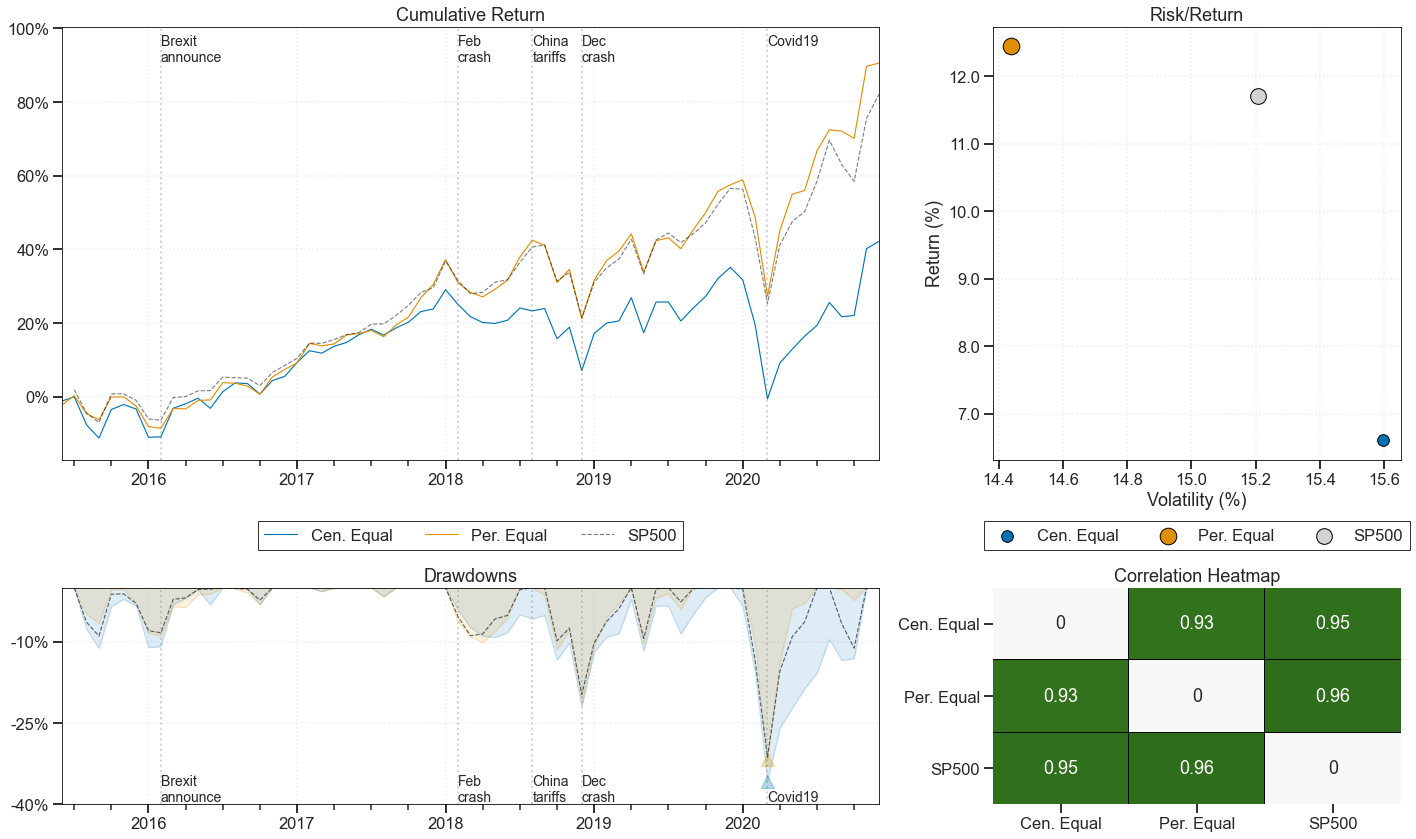

In [10]:
glance(portfolio=[port_central, port_peripheral], bm_price=bm, stress_events=stress_events)

### Visualize portfolio allocation

**Fix: Colors need to be fixed for sectors in donut plots.**

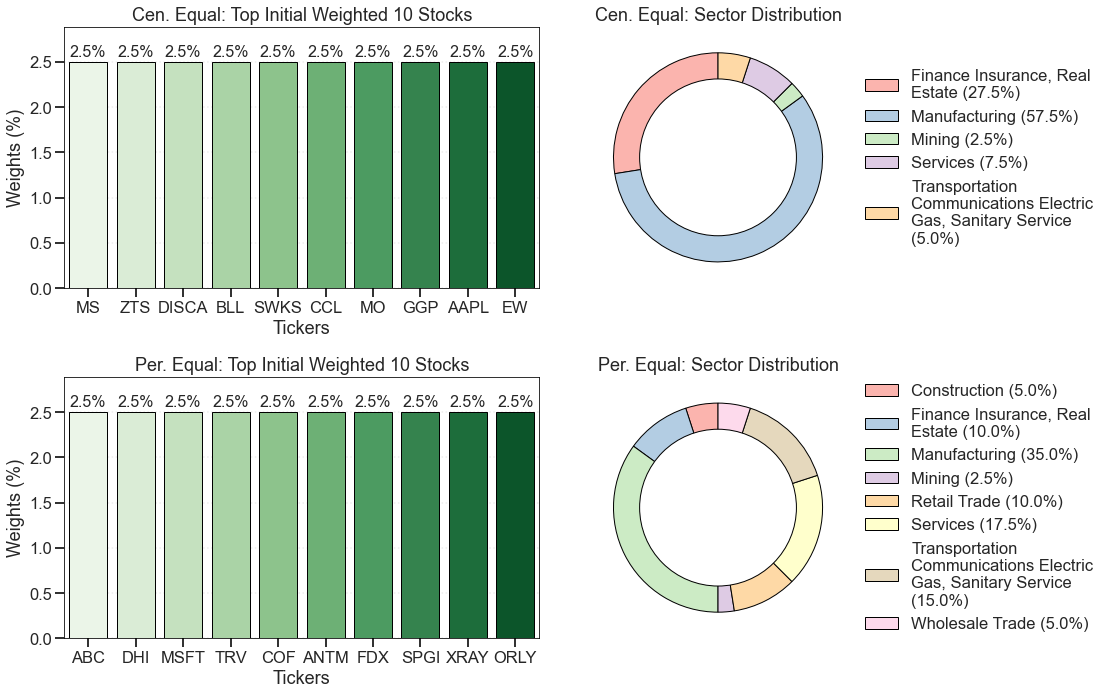

In [11]:
plot_ws_sector(port_central, attr, port_peripheral, attr)

### Average Sector Return

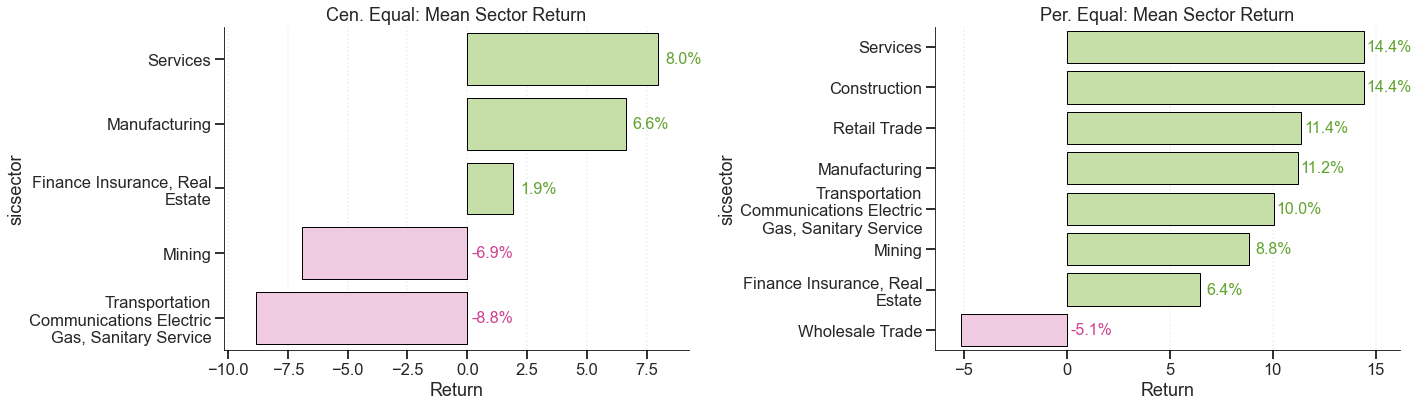

In [12]:
fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1,2,1)
plot_sector_metric(port_central, attr, annot=True)

fig.add_subplot(1,2,2)
plot_sector_metric(port_peripheral, attr, annot=True)  # metric='volatility'

sns.despine()

### Risk/return for n stocks in portfolios

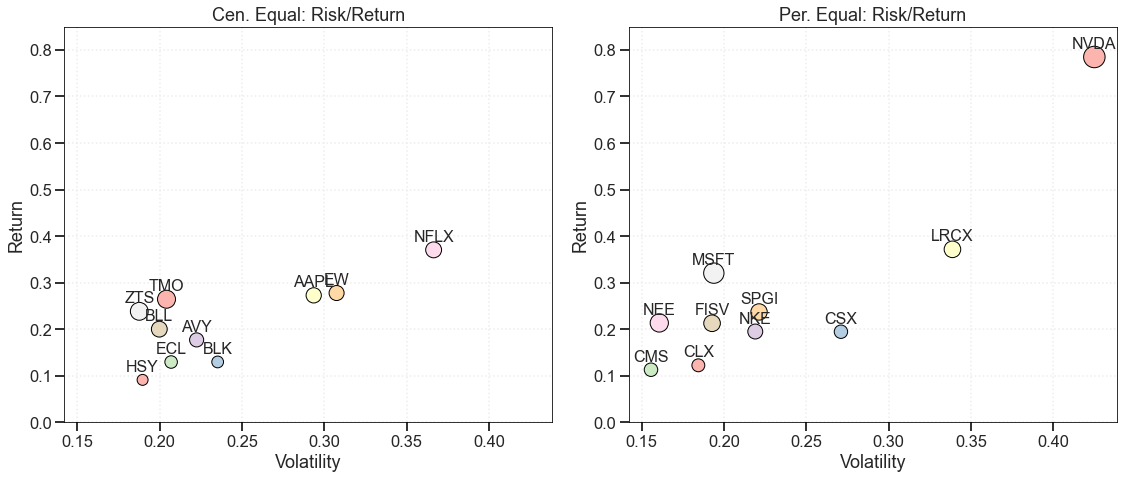

In [13]:
fig = plt.figure(figsize=(16,7))

n_stock =10

ax1 = fig.add_subplot(1,2,1)
plot_risk_return(port_central, annot=True, n_stock=n_stock, legend=False)

ax2 = fig.add_subplot(1,2,2, sharey=ax1, sharex=ax1)
plot_risk_return(port_peripheral, annot=True, n_stock=n_stock, legend=False)

ax1.set_ylim(0, 0.85)
plt.show()

### Closer look at central/peripheral stocks

The section below is a quick gut check. It looks at the cumulative returns for central and peripheral stocks between May 18, 2012 and May 17, 2015 to verify one class does not simply contain underperforming assets. Stock performance is also observed over the testing period. This section also takes a closer look at central and peripheral stocks to make sure they are not distinguished by factors like market cap (ie. central: large cap; peripheral: small cap). (Not included here is individual beta).

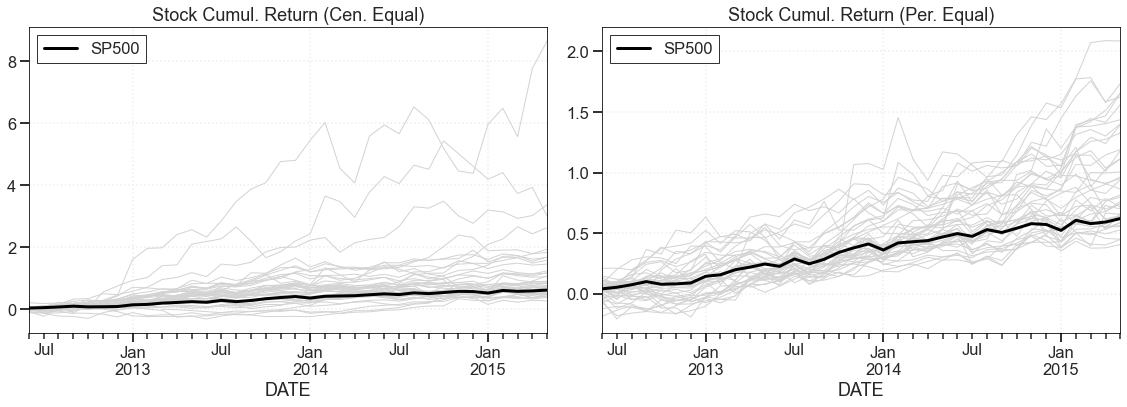

In [14]:
# Compute benchmark returns
bm_train = bm.loc[optimize_start: optimize_end].pipe(price_to_return)[0].pipe(return_to_cumul)

# Compute returns for central portfolio during optimization period
central_train = df.loc[optimize_start: optimize_end, port_central['assets']].pipe(price_to_return)[0]\
                                                                            .pipe(return_to_cumul)
# Compute returns for peripheral portfolio during optimization period
peripheral_train = df.loc[optimize_start: optimize_end, port_peripheral['assets']].pipe(price_to_return)[0]\
                                                                                  .pipe(return_to_cumul)
# Plot cumulative returns for stocks in each portfolio
fig,ax = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

c = 'lightgray'; cumul_title = 'Stock Cumul. Return ({})'

central_train.plot(legend=False, ax=ax[0], c=c, title=cumul_title.format(port_central['name']))
peripheral_train.plot(legend=False, ax=ax[1], c=c, title=cumul_title.format(port_peripheral['name']))

bm_train.plot(ax=ax[0], c='black', lw=3, legend=True)
bm_train.plot(ax=ax[1], c='black', lw=3, legend=True)

plt.show()

### Filter outlier and share y-axis

Stress events are not shown in the plots below to reduce clutter.

Removed: ['NFLX', 'GILD', 'GMCR']


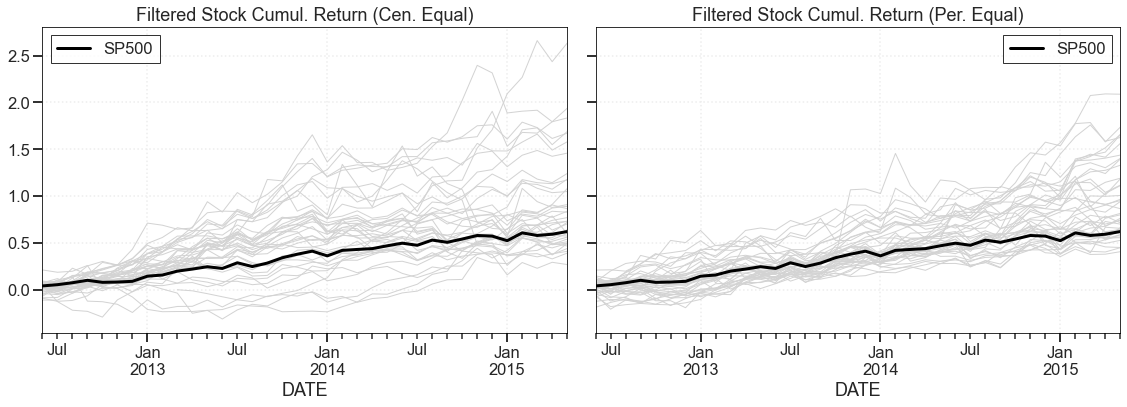

In [15]:
# Filter outlier from central cumulative returns
upper_cumul_threshold = 2.9
filtered_central_train = central_train.loc[:, central_train.iloc[-1] < upper_cumul_threshold]

print('Removed: {}'.format(list(set(central_train.columns) - set(filtered_central_train.columns))))

# Plot filtered cumulative returns
fig,ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

filtered_central_train.plot(legend=False, ax=ax[0], c=c, title='Filtered '+cumul_title.format(port_central['name']))
peripheral_train.plot(legend=False, ax=ax[1], c=c, title='Filtered '+cumul_title.format(port_peripheral['name']))

bm_train.plot(ax=ax[0], c='black', lw=3, legend=True)
bm_train.plot(ax=ax[1], c='black', lw=3, legend=True) # red

plt.show()

The cumulative returns for central and peripheral stocks between May 18, 2015 and December 31, 2020 are shown below.

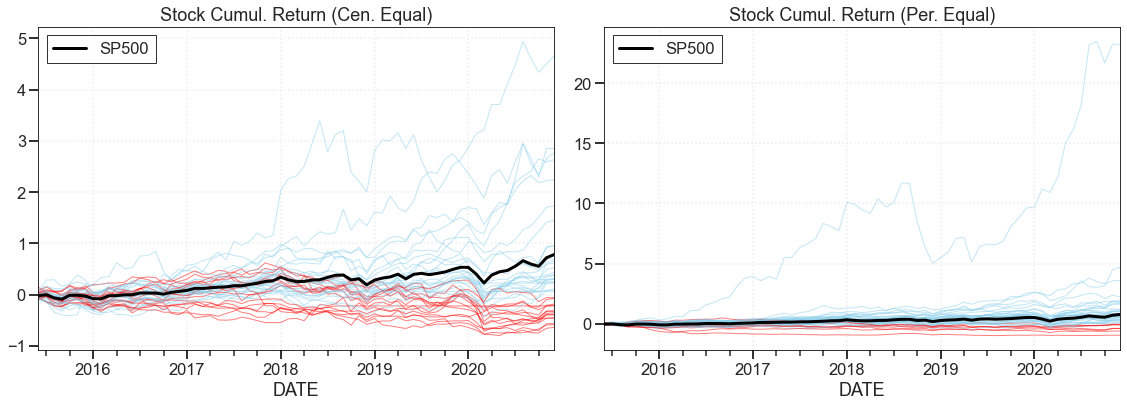

In [16]:
# Compute benchmark return for test period
bm_test = bm.loc[start_date: end_date].pipe(price_to_return)[0].pipe(return_to_cumul)

# Plot cumulative returns
fig,ax = plt.subplots(1, 2, figsize=(16, 6))

central_loss = ['skyblue' if c>0 else 'red' for c in port_central['stock_cumul'].iloc[-1]]
peripheral_loss = ['skyblue' if c>0  else 'red' for c in port_peripheral['stock_cumul'].iloc[-1]]

port_central['stock_cumul'].plot(legend=False, ax=ax[0], color=central_loss, alpha=0.5,
                                 title=cumul_title.format(port_central['name']))
port_peripheral['stock_cumul'].plot(legend=False, ax=ax[1], color=peripheral_loss, alpha=0.5,
                                    title=cumul_title.format(port_peripheral['name']))

bm_test.plot(ax=ax[0], c='black', lw=3, legend=True)
bm_test.plot(ax=ax[1], c='black', lw=3, legend=True)

plt.show()

### Filter outlier and share y-axis

In [17]:
port_peripheral['stock_cumul'].iloc[-1].nlargest(1)

ticker
NVDA    23.20244
Name: 2020-12-31 00:00:00, dtype: float64

Removed: ['NVDA']


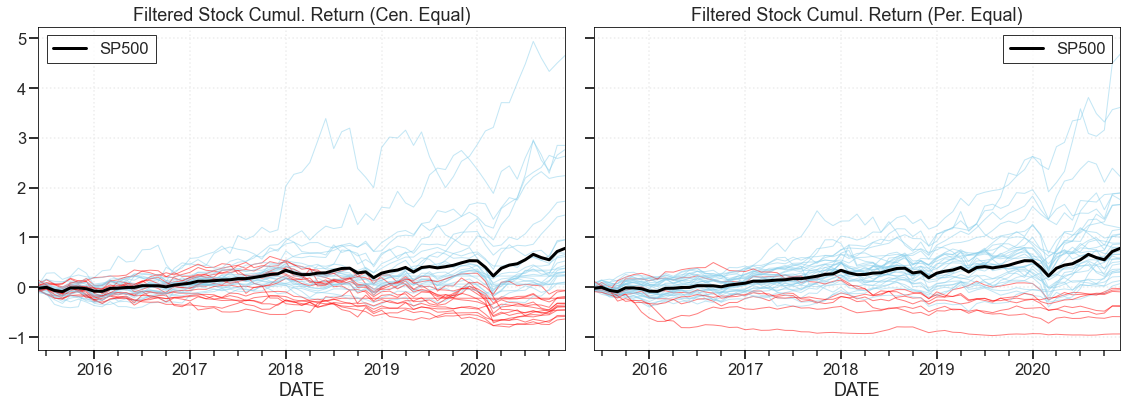

In [18]:
# Filter outlier from peripheral cumulative returns
remove_ticker = ['NVDA']
peipheral_test = port_peripheral['stock_cumul'].loc[:, ~port_peripheral['stock_cumul'].columns.isin(remove_ticker)]
print('Removed: {}'.format(remove_ticker))

# Plot filtered cumulative returns
fig,ax = plt.subplots(1,2,figsize=(16, 6), sharey=True)

peripheral_loss = ['skyblue' if c>0 else 'red' for c in peipheral_test.iloc[-1]]

port_central['stock_cumul'].plot(legend=False, ax=ax[0], color=central_loss, alpha=0.5, 
                                 title='Filtered ' + cumul_title.format(port_central['name']))
peipheral_test.plot(legend=False, color=peripheral_loss, ax=ax[1], alpha=0.5,
                    title='Filtered ' + cumul_title.format(port_peripheral['name']))

bm_test.plot(ax=ax[0], c='black', lw=3, legend=True)
bm_test.plot(ax=ax[1], c='black', lw=3, legend=True)

plt.show()

In [35]:
# Percentage of losing, winning stocks during testing period
print('Central Distribution:')
print(pd.cut(port_central['stock_cumul'].iloc[-1], bins=[-50, 0, 50], labels=['Loss', 'Gain'])\
                                        .value_counts(normalize=True).sort_index().round(2).to_string())

print('\nPeripheral Distribution:')
print(pd.cut(port_peripheral['stock_cumul'].iloc[-1], bins=[-50, 0, 50], labels=['Loss', 'Gain'])\
                                           .value_counts(normalize=True).sort_index().round(2).to_string())

Central Distribution:
Loss    0.38
Gain    0.62

Peripheral Distribution:
Loss    0.18
Gain    0.82


### Check market capitalization 

In [19]:
print('Central Market Cap Distribution:')
print(attr[attr.ticker.isin(central.columns)].scalemarketcap.value_counts(normalize=True).round(2).to_string())

print('\nPeripheral Market Cap Distribution:')
print(attr[attr.ticker.isin(peripheral.columns)].scalemarketcap.value_counts(normalize=True).round(2).to_string())

Central Market Cap Distribution:
5 - Large    0.95
6 - Mega     0.05

Peripheral Market Cap Distribution:
5 - Large    0.88
6 - Mega     0.12


### Simple portfolio optimization (max. sharpe ratio)

Calculate portfolio weights to maximize sharpe ratio over the period from May 18, 2012 to May 17, 2015. Portfolio performance is measured between (Monday) May 18, 2015 and December, 2020.

In [21]:
port_central_sharpe = make_portfolio(central, optimize_by='sharpe', start_date=start_date, end_date=end_date,
                                     optimize_start=optimize_start, optimize_end=optimize_end,
                                     lower_bound=0.015, upper_bound=0.1, 
                                     name='Cen. Sharpe')

port_peripheral_sharpe = make_portfolio(peripheral, optimize_by='sharpe', start_date=start_date, end_date=end_date,
                                        optimize_start=optimize_start, optimize_end=optimize_end,
                                        lower_bound=0.015, upper_bound=0.1, 
                                        name='Per. Sharpe')

### Visualize portfolio performance

,Cen. Sharpe,Per. Sharpe,SP500
Sharpe Ratio,0.60,0.81,0.77
Annualized Return,8.62%,11.41%,11.70%
Volatility,14.31%,14.10%,15.21%
Max. Drawdown,-26.24%,-25.65%,-31.32%
-,-,-,-
Information Ratio,-1.79,-0.19,-
Tracking Error,1.72%,1.48%,-
Beta,0.94,0.95,-


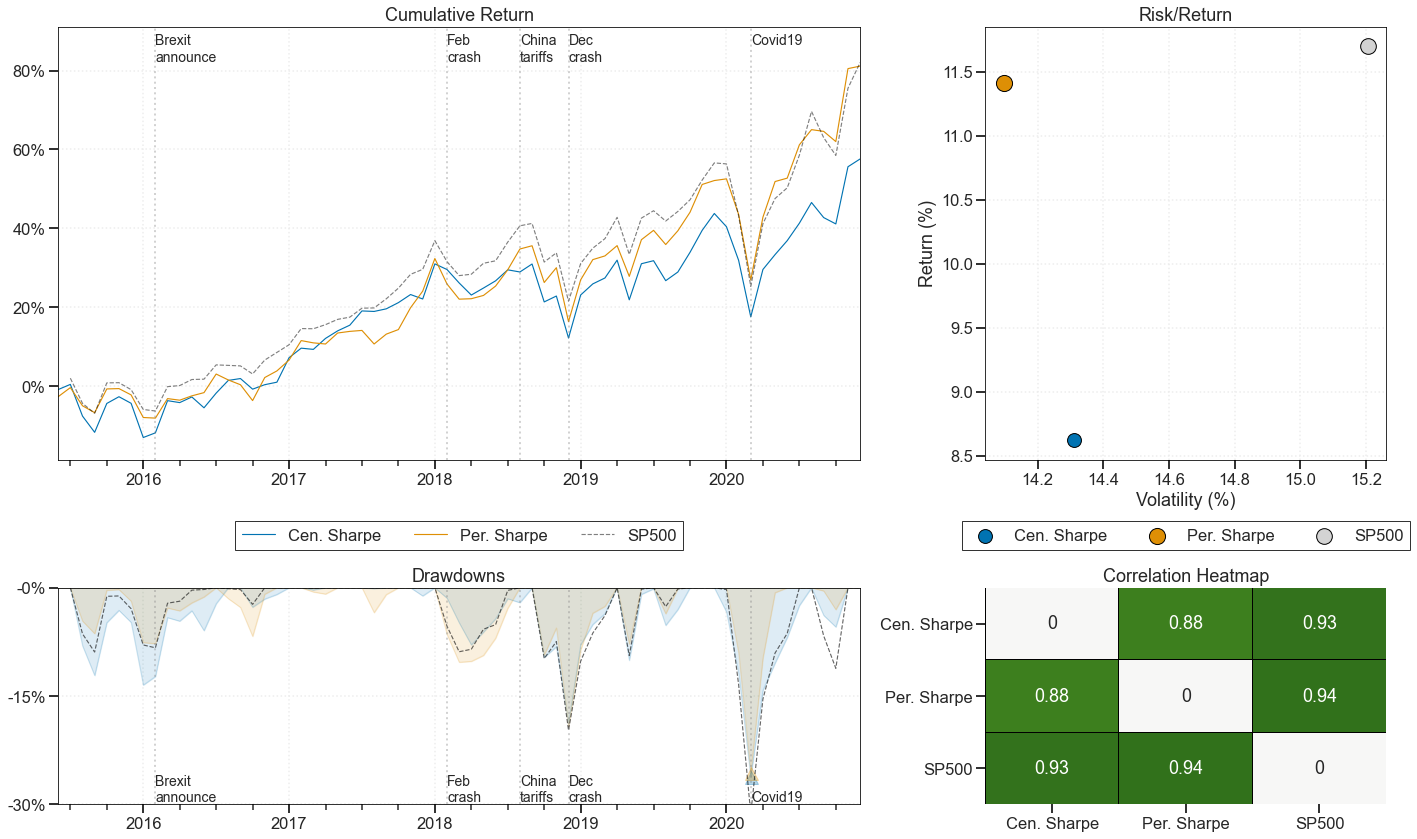

In [22]:
glance(portfolio=[port_central_sharpe, port_peripheral_sharpe], bm_price=bm, stress_events=stress_events)

### Compare portfolios to baseline

In [23]:
glance(portfolio=[port_central, port_central_sharpe, port_peripheral, port_peripheral_sharpe], 
       bm_price=bm, plot=False)

,Cen. Equal,Cen. Sharpe,Per. Equal,Per. Sharpe,SP500
Sharpe Ratio,0.42,0.60,0.86,0.81,0.77
Annualized Return,6.61%,8.62%,12.44%,11.41%,11.70%
Volatility,15.60%,14.31%,14.44%,14.10%,15.21%
Max. Drawdown,-35.71%,-26.24%,-31.60%,-25.65%,-31.32%
-,-,-,-,-,-
Information Ratio,-3.25,-1.79,0.59,-0.19,-
Tracking Error,1.57%,1.72%,1.26%,1.48%,-
Beta,1.06,0.94,1.00,0.95,-


### Visualize portfolio allocation

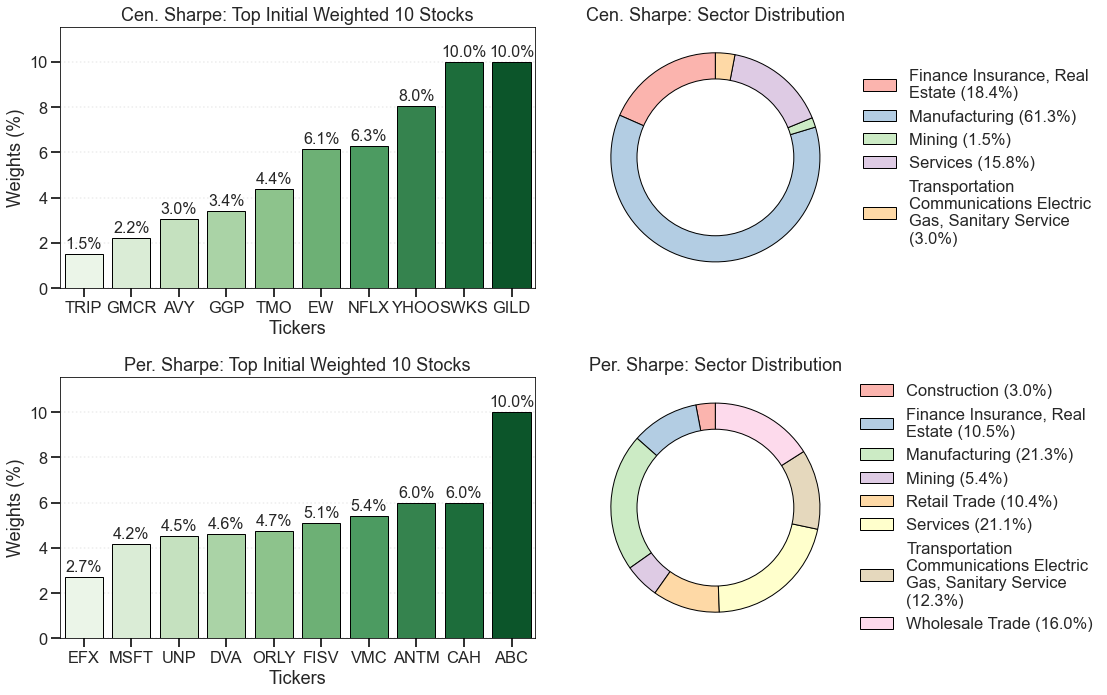

In [24]:
plot_ws_sector(port_central_sharpe, attr, port_peripheral_sharpe, attr)

### Closer look at top weighted stock

In [25]:
# Get ticker for top weighted stock in portfolio
def get_top_weighted_stocks(port_result, n_stock):
    ws_idx = np.argpartition(port_result['weights'], -n_stock)[-n_stock:]
    top_ws = port_result['weights'][ws_idx]
    top_assets = port_result['assets'][ws_idx]
    return top_assets, top_ws

In [26]:
top_n = 5

# Get top weighted central stock
central_sharpe_top_assets, _ = get_top_weighted_stocks(port_central_sharpe, top_n)

# Get top weighted peripheral stock
peripheral_sharpe_top_assets, _ = get_top_weighted_stocks(port_peripheral_sharpe, top_n)

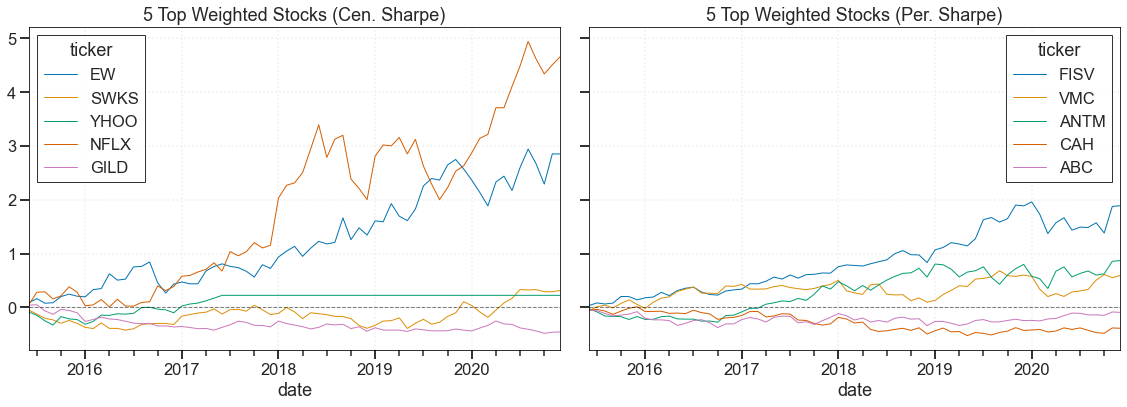

In [27]:
# Plot cumulative return for top weighted stocks
fig,ax = plt.subplots(1,2,figsize=(16, 6), sharey=True)

top_n_title = str(top_n) + ' Top Weighted Stocks ({})'

port_central_sharpe['stock_cumul'].loc[:, central_sharpe_top_assets]\
                                  .plot(ax=ax[0], title=top_n_title.format(port_central_sharpe['name']))
port_peripheral_sharpe['stock_cumul'].loc[:, peripheral_sharpe_top_assets]\
                                     .plot(ax=ax[1], title=top_n_title.format(port_peripheral_sharpe['name']))

ax[0].axhline(y=0, c='black', alpha=0.5, ls='--')
ax[1].axhline(y=0, c='black', alpha=0.5, ls='--')
plt.show()

### Simple portfolio optimization (min. volatility)

Calculate portfolio weights to minimize volatility over the period from May 18, 2012 to May 17, 2015. Portfolio performance is measured between (Monday) May 18, 2015 and December, 2020.

In [28]:
port_central_vol = make_portfolio(central, optimize_by='volatility', start_date=start_date, end_date=end_date,
                                  optimize_start=optimize_start, optimize_end=optimize_end,
                                  lower_bound=0.01, upper_bound=0.1, name='Cen. Vol')

port_peripheral_vol = make_portfolio(peripheral, optimize_by='volatility', start_date=start_date, end_date=end_date,
                                     optimize_start=optimize_start, optimize_end=optimize_end,
                                     lower_bound=0.01, upper_bound=0.1, name='Per. Vol')

### Visualize portfolio performance

,Cen. Vol,Per. Vol,SP500
Sharpe Ratio,0.44,0.96,0.77
Annualized Return,6.63%,12.29%,11.70%
Volatility,15.24%,12.76%,15.21%
Max. Drawdown,-38.81%,-23.95%,-31.32%
-,-,-,-
Information Ratio,-3.57,0.43,-
Tracking Error,1.42%,1.40%,-
Beta,1.04,0.86,-


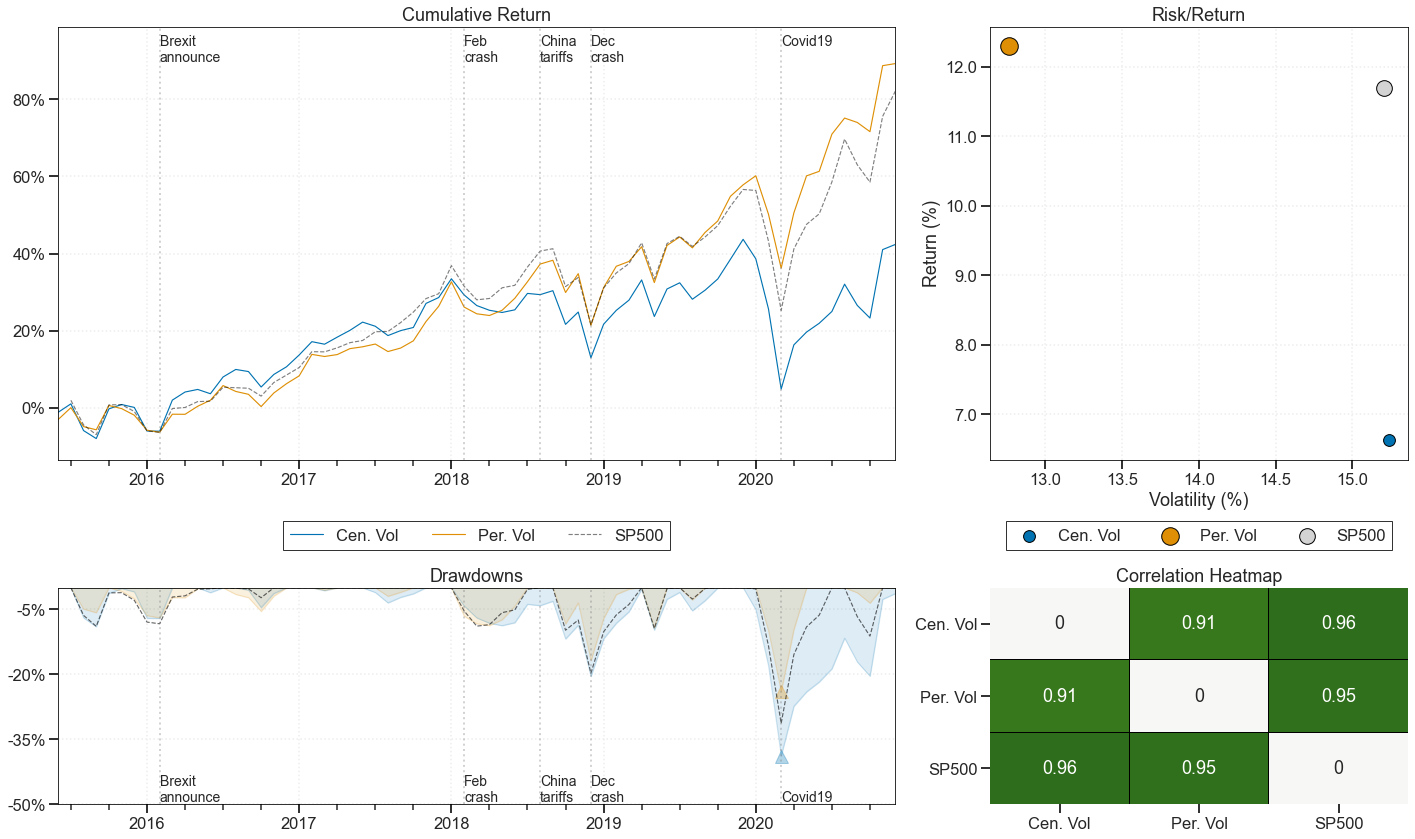

In [29]:
glance(portfolio=[port_central_vol, port_peripheral_vol], bm_price=bm, stress_events=stress_events)

### Compare portfolio to baseline

In [30]:
glance(portfolio=[port_central, port_central_sharpe, port_central_vol, 
                  port_peripheral, port_peripheral_sharpe, port_peripheral_vol], 
       bm_price=bm, plot=False)

,Cen. Equal,Cen. Sharpe,Cen. Vol,Per. Equal,Per. Sharpe,Per. Vol,SP500
Sharpe Ratio,0.42,0.60,0.44,0.86,0.81,0.96,0.77
Annualized Return,6.61%,8.62%,6.63%,12.44%,11.41%,12.29%,11.70%
Volatility,15.60%,14.31%,15.24%,14.44%,14.10%,12.76%,15.21%
Max. Drawdown,-35.71%,-26.24%,-38.81%,-31.60%,-25.65%,-23.95%,-31.32%
-,-,-,-,-,-,-,-
Information Ratio,-3.25,-1.79,-3.57,0.59,-0.19,0.43,-
Tracking Error,1.57%,1.72%,1.42%,1.26%,1.48%,1.40%,-
Beta,1.06,0.94,1.04,1.00,0.95,0.86,-


### Visualize portfolio allocation

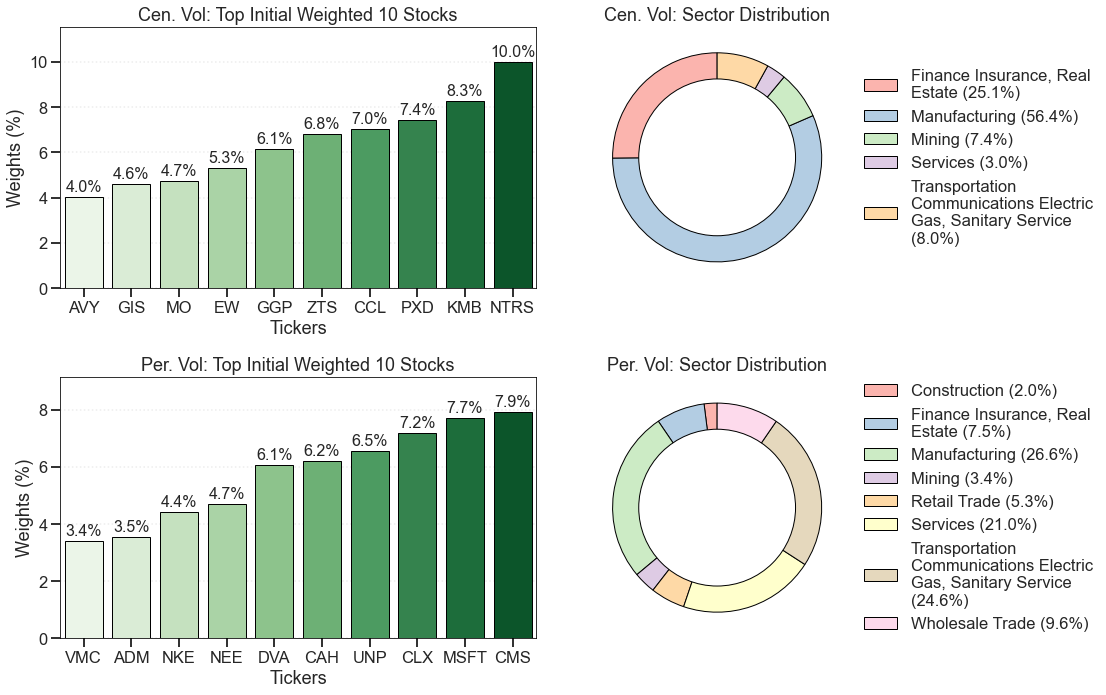

In [31]:
plot_ws_sector(port_central_vol, attr, port_peripheral_vol, attr)

### Closer look at top weighted stock performance

In [32]:
# Get top weighted central stock
central_vol_top_assets, _ = get_top_weighted_stocks(port_central_vol, top_n)

# Get top weighted peripheral stock
peripheral_vol_top_assets, _ = get_top_weighted_stocks(port_peripheral_vol, top_n)

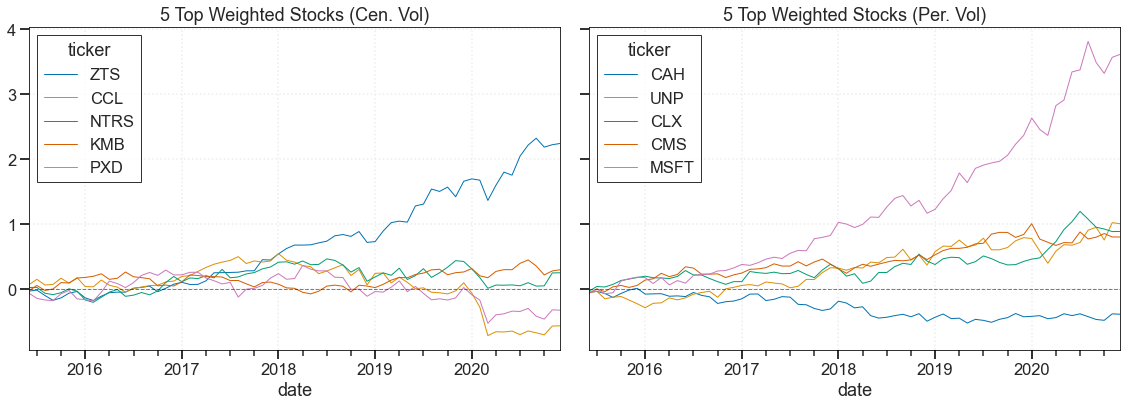

In [33]:
# Plot cumulative return for top weighted stocks
fig,ax = plt.subplots(1,2,figsize=(16, 6), sharey=True)

port_central_vol['stock_cumul'].loc[:, central_vol_top_assets]\
                               .plot(ax=ax[0], title=top_n_title.format(port_central_vol['name']))
port_peripheral_vol['stock_cumul'].loc[:, peripheral_vol_top_assets]\
                                  .plot(ax=ax[1], title=top_n_title.format(port_peripheral_vol['name']))

ax[0].axhline(y=0, c='black', alpha=0.5, ls='--')
ax[1].axhline(y=0, c='black', alpha=0.5, ls='--'); plt.show()

### Portfolio calendar heatmap

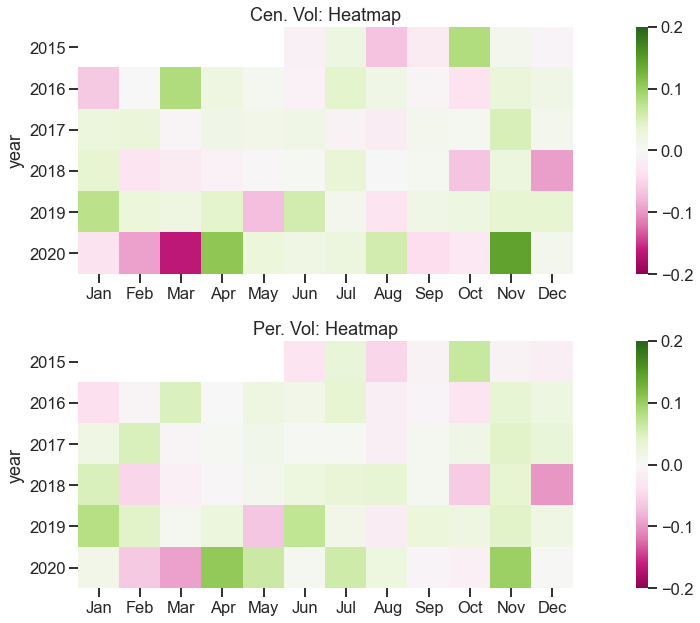

In [34]:
fig = plt.figure(figsize=(18, 9))

vmin=-0.2; vmax=0.2

fig.add_subplot(2,1,1)
calendar_heatmap(port_central_vol, vmin=vmin, vmax=vmax)

fig.add_subplot(2,1,2)
calendar_heatmap(port_peripheral_vol, vmin=vmin, vmax=vmax ) #, lc='black')